In [94]:
import numpy as np
import matplotlib.pyplot as plt

font = {'family' : 'normal',
        'weight' : 'bold',
        'size': 16}
plt.rc('font', **font)

from HuffmanFUNC import *
from MASKING import *

In [95]:
from scipy.io import wavfile
audiofile = "Track16.wav"
encoded = "encoded.bin"
encoded_hw3 = "encoded_hw3.bin"

fs, signal = wavfile.read(audiofile)

start = 0
N = 64  # MDCT sub-bands
nfft = 2*(N-1)
T = 102_400 #  #30_000 # in samples  (440_000)
quality = 80
st = 40 # time scalefactor

x = signal[start:start+T, :]
x0 = [*x[:, 0]]

def map2hz_mat1(W, nfft):
    nfreqs = int(nfft/2)
    tmp1 = np.diag((1.0/(np.sum(W,1)+0.01))**0.5)
    W_inv = np.dot(np.diag((1.0/(np.sum(W,1)+0.01))**0.5), W[:,0:nfreqs + 1]).T
    return W_inv

def pow2(x):
    return np.floor(np.log2(x))

In [96]:
# mdct -> masking threshold -> quantization -> coding
fb = Filter_banks(x0, N)
fb.analysis()

# Mapping to bark scale
W, nfilts, max_brk = map2brk_mat(fs, nfft)
Zxx_brk = map2brk(fb.y2, W, nfft)**2
sf_mat = SF_mat(max_brk, nfilts)
W_inv = map2hz_mat1(W, nfft)

bit_steps_mat = np.zeros((fb.y2.shape[0], fb.y2.shape[1]//st), dtype=np.int)
new_steps = np.zeros((fb.y2.shape[0], fb.y2.shape[1]//st), np.int)
x2 = np.zeros_like(fb.y2)

# Quantization and steps saving
for i in range(fb.y2.shape[1]//st):  # 160
    x1 = Zxx_brk[i*st, :]
    mt_bark2 = MTQ_bark(x1, sf_mat, max_brk, nfilts) /(quality/100)
    mt2 = map2hz(mt_bark2, W_inv, nfft)
    
    steps = np.sqrt(12*mt2)
    bit_steps = pow2(steps)
    a = np.min(bit_steps) - 1
    bit_steps -= a
    bit_steps_mat[:, i] = bit_steps
    
for i in range(N):
    new_steps[i, :] = 1+(np.max(fb.y2[i, :]) - np.min(fb.y2[i, :])) / (2**bit_steps_mat[i, :])
    for j in range(fb.y2.shape[1]//st):
        x2[i, st*j:st*j+st] = fb.y2[i, st*j:st*j+st] / new_steps[i, j]


x2 = x2.astype(np.int)
pickle.dump([new_steps, x2], open(encoded, "wb"), 1) 

# Prepairing data for Huffman coding and saving in file
decod_dicts = []
steps = []
lens = []
coded_strings = bitarray()
    
for i in range(N):
    huffman = Huffman(x2[i, :])
    decod_dict, coded_string = huffman.encode()
    decod_dicts.append(decod_dict)
    lens.append(len(coded_string))
    coded_strings.extend(coded_string)

# saving file
pickle.dump([new_steps, decod_dicts, coded_strings, lens], open(encoded_hw3, "wb"), 1)


print(os.path.getsize(encoded) / 1024)
print(os.path.getsize(encoded_hw3) / 1024)

892.513671875
89.0615234375


<ipython-input-96-6e3fb7b240f7>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bit_steps_mat = np.zeros((fb.y2.shape[0], fb.y2.shape[1]//st), dtype=np.int)
<ipython-input-96-6e3fb7b240f7>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional 

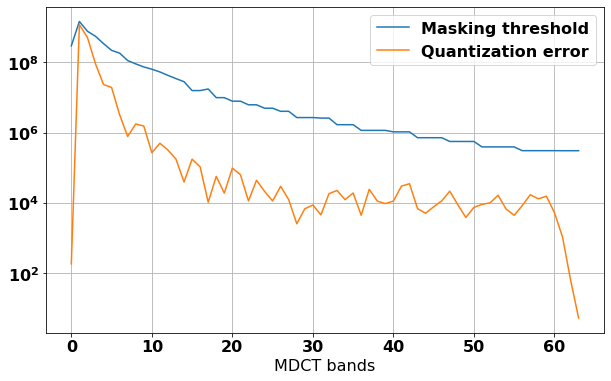

In [97]:
i = 60
x1_i = Zxx_brk[i, :]
mt_bark2_i = MTQ_bark(x1_i, sf_mat, max_brk, nfilts) /(quality/100)
mt2_i = map2hz(mt_bark2_i, W_inv, nfft)

fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot()
ax.semilogy(mt2_i)
ax.semilogy(new_steps[:, i//st]**2 / 12)
plt.legend(["Masking threshold", "Quantization error"])
plt.xlabel("MDCT bands")
plt.grid()

In [98]:
# decode 1
[new_steps_dec, x2_dec] = pickle.load(open(encoded, "rb"))
x_hat = np.zeros_like(x2_dec)
for i in range(x2_dec.shape[1]):
    x_hat[:, i] = x2_dec[:, i] * new_steps_dec[:, i//st]
x_hat1 = fb.synthesis(x_hat)

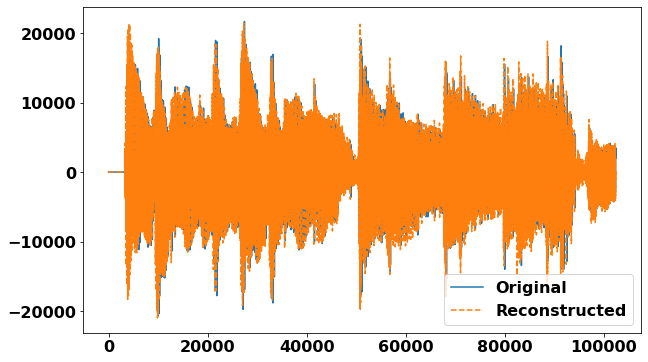

In [99]:
fig = plt.figure(figsize = (10, 6))
plt.plot(x_hat1)
plt.plot(x0, '--')
plt.legend(["Original", "Reconstructed"])

In [100]:
# decode 2
[new_steps_dec, decod_dicts_dec, coded_strings_dec, lens_dec] = pickle.load(open(encoded_hw3, "rb"))

r = 0
y2_dec1 = np.zeros_like(x2_dec)
y2_dec2 = np.zeros_like(x2_dec)
for i in range(N):
    y2_dec1[i, :] = decode_h(decod_dicts_dec[i], coded_strings_dec[r:r+lens[i]])
    y2_dec2[i, :] = y2_dec1[i, :] * np.repeat(new_steps_dec[i], st)
    r += lens[i]
x_hat2 = fb.synthesis(y2_dec2)

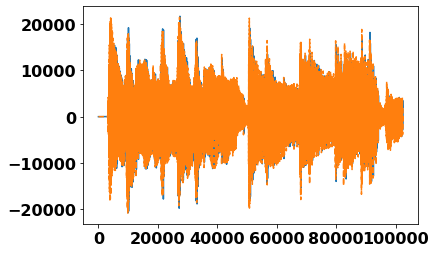

In [101]:
plt.plot(x_hat1)
plt.plot(x0, '--')

In [102]:
wavfile.write("restored1.wav", rate=fs, data=x_hat1.astype(np.int16))
wavfile.write("restored2.wav", rate=fs, data=x_hat2.astype(np.int16))